#  $k$-NN Classifier 


### 1. Dataset and problem description

The Healthy Body dataset contains body measurements acquired from **1250 people _from different ages, genders, and nationalities_** from different hospitals around the world. Health professionals have performed medical examinations and classified the individuals into three different body categories: **underweight, normal weight, and overweight.**

The program uses the features height and weight to train a $k$-NN classifier for predicting body category.

---

In [6]:
# Enable interactive plots, so you can zoom/pan/resize plots
%matplotlib notebook

import numpy as np
from matplotlib import pyplot as plt

## 2. Data loading and visualization

The goal of supervised classification algorithms such as $k$-NN is to use information from a set of labeled examples, i.e., examples for which we know their class assignments, to infer the classes for unlabeled examples.

In [7]:
# Data loading

# Paths
features_annotated_path = "hbody_feats_annotated.npy"     # Weights, heights of individuals with known body category
labels_annotated_path = "hbody_labels_annotated.npy"      # Body categories of those individuals
features_unannotated_path = "hbody_feats_unannotated.npy" # Weights and heights of unknown body category individuals
                                                          # - Goal: Figure out their body categories

# Features organized in an NxD matrix; N examples, D features.
# Another way to look at it: each of the N examples is a D-dimensional feature vector.

features_annotated = np.load(features_annotated_path)
features_unannotated = np.load(features_unannotated_path)
labels_annotated = np.load(labels_annotated_path)

class_names = ('Underweight', 'Normal weight', 'Overweight')


<IPython.core.display.Javascript object>


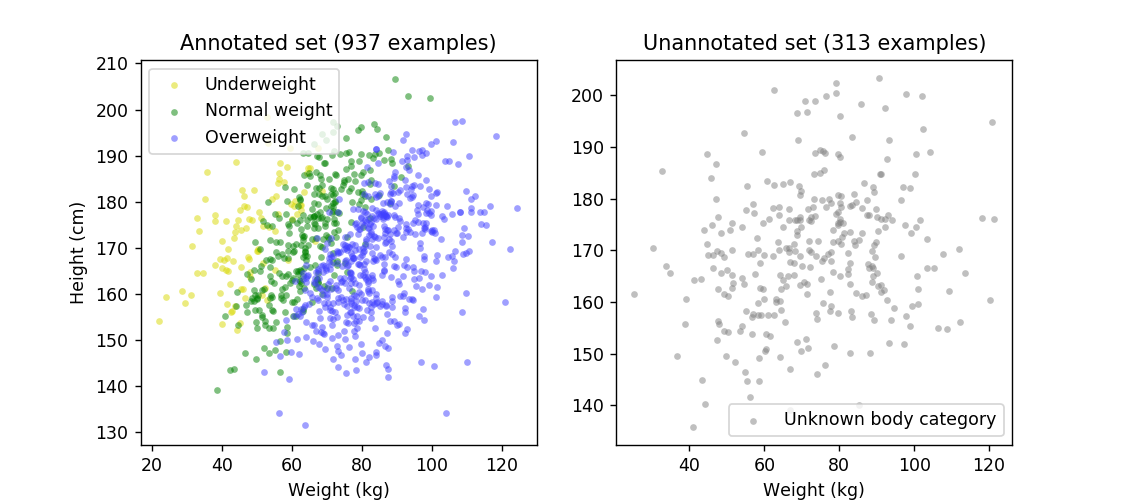

In [8]:
# Visualize annotated and unannotated sets

colors = np.array([[0.85, 0.85, 0], [0, 0.5, 0], [0.25, 0.25, 1]])

plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.title(f"Annotated set ({len(labels_annotated)} examples)")
for i, class_name in enumerate(class_names):
    plt.scatter(*features_annotated[labels_annotated==i].T,
                c=colors[i, None], alpha=0.5, s=15, lw=0, label=class_name)
plt.xlabel("Weight (kg)")
plt.ylabel("Height (cm)")
plt.legend();

plt.subplot(1,2,2)
plt.title(f"Unannotated set ({len(features_unannotated)} examples)")
plt.scatter(*features_unannotated.T, c='gray', alpha=0.5, s=15, lw=0, label='Unknown body category')
plt.xlabel("Weight (kg)")
plt.legend();

We can see that, except for amibiguity at the class boundaries, classes are separated from each other. 

---

### 2.1 Normalizing data

$k$-NN determines neighbors by computing the "distance" between two examples. For this process to work, we are required
to normalize the features. This is true for many other machine learning algorithms as well.

This is important in order to not get widely different orders of magnitude in each dimension, as different features will have different range of values. For example if we have a feature corresponding to salary of a person vs his/her weight. The salary will be in order of 10^5 and weight will be less than 10^2, which means while computing distances between two data points, salary will be overpower in computation. The iterative algorithms might take time to converge without proper normalization..

A very common way to normalize the data is by the so-called z-score standardization. It transforms values from an arbitrary range such that the result has mean $0$ and standard deviation $1$. The operation is defined as follows:

$$
x_{norm} = \frac {x - \mu_x} {\sigma_x},
$$
for _each feature independently_.



In [9]:
# Normalize the data.
def normalize(features, means, stds):

    return (features - means) / stds

## 3. The $k$-Nearest Neighbors Classifier

$k$-NN assigns as label to a given example the most popular label from its surroundings. The method is very intuitive, and can be summarized as:
- Compute the distance between the example to classify and all the training examples.
- Select the closest $k$ training examples.
- Assign to the example the most common label among those neighbors.

### 3.1 Distance metrics

There are many ways to define a distance between two examples. Two very common ones that we will use in this exercise are:

#### Euclidean distance (L2 norm):

$$
{L_2}(\mathbf{v}, \mathbf{w}) = \sqrt{ \sum_{i=1}^d \left(\mathbf{v}_i - \mathbf{w}_i\right)^2 }
$$

#### Manhattan distance (L1 norm):

$$
{L_1}(\mathbf{v}, \mathbf{w}) = \sum_{i=1}^d |\mathbf{v}_i - \mathbf{w}_i|
$$

In [10]:
def euclidean_dist(example, training_examples):
    return np.sqrt(((training_examples - example) ** 2).sum(axis=1))

def manhattan_dist(example, training_examples):
    # WRITE YOUR CODE HERE
    return np.abs(training_examples - example).sum(axis=1)

def find_k_nearest_neighbors(k, distances):
    indices = np.argsort(distances)[:k]
    return indices

def predict_label(neighbor_labels):
    return np.argmax(np.bincount(neighbor_labels))

### 3.2 $k$-NN Step by Step for a Single Example
Let's implement the algorithm for one example in this section.


In [11]:
# Choosing a random training example and treating as we don't know it's true label. 
total_samples = features_annotated.shape[0]
dummy_unknown = np.random.choice(np.arange(total_samples),1)[0]
all_indices = np.arange(total_samples)
known_label = np.delete(all_indices,dummy_unknown)

# Get the features corresponding to known and unknown points
train_labels = labels_annotated[known_label]
train_feats = features_annotated[known_label,:]
dummy_unknown_feats =  features_annotated[dummy_unknown,:]


# Standardizing the data
mean_val = train_feats.mean(0,keepdims=True)
std_val = train_feats.std(0,keepdims=True)
norm_train_feats = normalize(train_feats,mean_val,std_val)
norm_dummy_unknown_feats = normalize(dummy_unknown_feats,mean_val,std_val)

# number of neighbors
k=6

# find distance w.r.t all training examples
distances = euclidean_dist(norm_dummy_unknown_feats, norm_train_feats)
# find the nearest neighbors
nn_indices = find_k_nearest_neighbors(k, distances)
# find labels of nearest neighbors
neighbor_labels = train_labels[nn_indices] 
# find the best label
best_label = predict_label(neighbor_labels) 

print(f'Predicted label: {class_names[best_label]}')

Predicted label: Normal weight


<IPython.core.display.Javascript object>


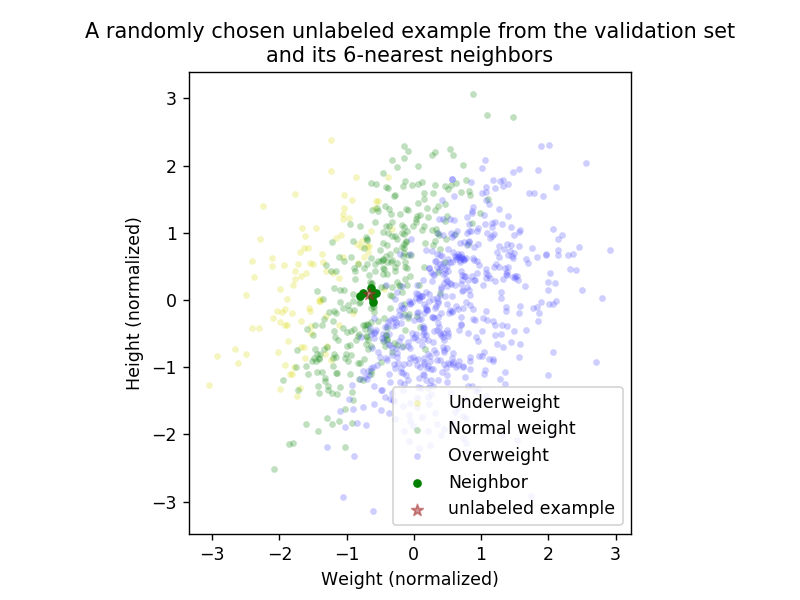

In [12]:
# Visualize the unknown point and its neighbors.
plt.figure()
plt.title(f"A randomly chosen unlabeled example from the validation set\nand its {k}-nearest neighbors")
for i, class_name in enumerate(class_names):
    plt.scatter(*norm_train_feats[train_labels==i].T,
                c=colors[i, None], alpha=0.25, s=15, lw=0, label=class_name)
for i, class_name in enumerate(class_names):
    class_indices = nn_indices[train_labels[nn_indices] == i]
    if len(class_indices) > 0:
        plt.scatter(*norm_train_feats[class_indices].T,
                    c=colors[i, None], alpha=1, s=25, lw=0, label='Neighbor')

ax = plt.scatter(*norm_dummy_unknown_feats[0], marker='*', c='brown', alpha=0.5, s=50, label='unlabeled example')
plt.xlabel("Weight (normalized)")
plt.ylabel("Height (normalized)")
plt.gca().set_aspect('equal')
plt.legend();

### 3.3 Putting things together

In [13]:
# kNN_one_example applies all the previous steps
# to predict the label of one example.

def kNN_one_example(unlabeled_example, training_features, training_labels, k):
    distances = euclidean_dist(unlabeled_example, training_features)  # Compute distances
    nn_indices = find_k_nearest_neighbors(k, distances)               # Find neighbors
    neighbor_labels = training_labels[nn_indices]                     # Get neighbors' labels
    best_label = predict_label(neighbor_labels)                       # Pick the most common
    
    return best_label

def kNN(unlabeled, training_features, training_labels, k):
    return np.apply_along_axis(kNN_one_example, 1, unlabeled, training_features, training_labels, k)

## 4 Cross Validation

### 4.1 Splitting the annotated data into training, validation, and test sets

We need to ensure that our method generalizes, which means it will correctly predict the class for new provided examples.

In order to simulate this scenario, we will split our annotated data into two groups: the training set, and the test set.
- The **training set** will be used for finding a set of parameters and hyperparameters minimizing a given criterion.
- The **test set** will be used for testing how well the learned model generalizes to data beyond that used for training.

While the training set helps us find out how exactly to manipulate our data to find the right prediction, the test set tells us how well we expect to perform when given new data. Our training procedure is allowed to handle data from the training set only, and should not in any way use the information from the test set.

In [14]:
# Split labeled data into training and test set

# Choose a fixed seed to reproduce same results
np.random.seed(330)

num_annotated_labels = len(labels_annotated)

# percentage of annotated data for train and test sets.
training_perc, test_perc = 0.8, 0.2

indices = np.arange(len(labels_annotated))
np.random.shuffle(indices)

num_train_samples = int(training_perc*num_annotated_labels)
num_test_samples = num_annotated_labels-num_train_samples

# split indices into train and test folds
training_indices, test_indices = np.split(indices,indices_or_sections=[num_train_samples])

# Get the training and test data and labels
training_features = features_annotated[training_indices]
training_labels = labels_annotated[training_indices]
test_features = features_annotated[test_indices]
test_labels = labels_annotated[test_indices]

In [15]:
# Normalize the features of train and test data with mean 0 and std 1
mean_features = training_features.mean(axis=0)
std_features = training_features.std(axis=0)

norm_train_features = normalize(training_features,mean_features,std_features)
norm_test_features = normalize(test_features,mean_features,std_features)


### 4.2 K-Fold Cross-validation

If we are only allowed to assess our model generalization _after_ training, how can we monitor and guide the training process? How can we know beforehand that we are using the best version of our model?

The most common strategy for this, called **[cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics))**, is, simply put, to pretend that a part of our training data is in fact unannotated, and see if our method manages to predict the annotations correctly. In other words, we will reserve a portion of our training data to temporarily act as a small test set. 

Cross Validation(CV) technique is used to choose the best parameters for separate validation set, where the hope is that this set will be close to the (unseen) test set. We train our model on train set and use hyperparameters which give best results on validation set. This is a general technique to choose your best machine learning model.

K-fold is a type of CV technique that we'll see here. We'll split data in K parts and use kth part for validation, whereas k-1 for training. This process will be repeated K times. Metric used to evaluate the model is accuracy on the validation set.

Splitting your training data into a training and a validation set is also used for comparing different "versions" of your model. Many machine learning methods depend on predefined configuration settings, called _hyperparameters_, that heavily influence how the method behaves. In the case of $k$-NN, one such parameter is $k$, the number of neighbors.

Here, we will be applying k-fold cross validation. Technically, the validation set is part of the training data. To avoid confusion, however, the _training set_ often refers to the portion of your training data used for tuning your method. Therefore, for k-fold cross validation, the annotated data is split into training data, and a test set. Further, the training data is split into k-folds from which one fold is used for validation set and rest of the folds as training set. This process is repeated K times and average performance is calculated. The value of hyperparameter is chosen to minimise the error on the cross-validations set. 

In [16]:
# Function to split data indices

# Inputs:
#        num_examples: total samples in the dataset
#        k_fold: number fold of CV
# 
# Output: array of shuffled indices with shape (k_fold, num_examples//k_fold)

def fold_indices(num_examples,k_fold):
    ind = np.arange(num_examples)
    split_size = num_examples//k_fold
     
    k_fold_indices = []

    # Generate k_fold set of indices
    k_fold_indices = [ind[k*split_size:(k+1)*split_size] for k in range(k_fold)]
         
    return np.array(k_fold_indices)


### 4.3 Performance metric to know if the  prediction is good?

In order to quantify the performance of our model, we want to obtain a score that tells us how close the predictions were to the expected classification.

The simplest way to do this is to compute the ratio of correctly predicted examples, also known as the accuracy:

$$
\frac 1 N \sum_{n=1}^N \mathbf{1}[\hat{y} = y]
$$


In [17]:
# Computes the accuracy between a predicted and the expected labels.
def accuracy(predicted, target):
    return np.mean(predicted == target)

In [18]:
# kNN function using kth split as validation set and rest k-1 splits to train model. 

#Inputs:
#   k_fold - kth fold as cross validation split
#   k_fold_ind -  indices of each split of k-fold split
#   X  -  training data
#   Y  - train labels
#   k - number of nearest neighbours for k-NN algorithm

#Outputs:  return the accuracy of validation set

def kNN_CV(k_fold,k_fold_ind,X,Y,k ):
    
    #use kth split for validation
    val_ind = k_fold_ind[k_fold]
    
    # use rest k-1 splits to train
    train_splits = [i for i in range(k_fold_ind.shape[0]) if i is not k_fold]
    train_ind = k_fold_ind[train_splits,:].reshape(-1)
    
    #Get train and val 
    X_train = X[train_ind,:]
    Y_train = Y[train_ind]
    X_val = X[val_ind,:]
    Y_val = Y[val_ind]
    
    
    Y_val_pred = kNN(X_val, X_train, Y_train, k)
    
    #get accuracy for val
    acc = accuracy(Y_val_pred, Y_val)
    return acc

### 4.4 Putting it all together

In [19]:
# Perform a 4-fold cross validation on training dataset

k =  4  # number of nearest neighbours for k-NN
k_fold = 4
k_fold_ind = fold_indices(norm_train_features.shape[0],k_fold)
acc = np.zeros(k_fold)
for fold in range(k_fold):
    # Get validation accuracy with kth fold as validation set and rest as training set
    # WRITE YOUR CODE HERE
    acc[fold] = kNN_CV(fold,k_fold_ind,norm_train_features,training_labels, k)
mean_acc = np.mean(acc)

print(f"{k}-NN Classifier predicted correctly  with accuracy of {mean_acc:.2%} on cross-validation set")

4-NN Classifier predicted correctly  with accuracy of 83.82% on cross-validation set


### 4.5 Hyperparameter optimization

Was the best value for $k$ chosen?

We can evaluate the model under different values of $k$ to compare them. A simple way to do it is to evaluate our model's predictions for the same validation set when using different values of $k$.


In [20]:
# Call the CV with different k values

def run_cv_for_hyperparam(k_values, k_fold,norm_train_features,training_labels):

    k_fold_ind = fold_indices(norm_train_features.shape[0],k_fold)
    model_performance = []  # Store the computed metrics here
    for k in k_values:
        for fold in range(k_fold):
            # WRITE YOUR CODE HERE
            acc[fold] = kNN_CV(fold,k_fold_ind,norm_train_features,training_labels, k)
        mean_acc = np.mean(acc)
        model_performance.append(mean_acc)
        
    return model_performance


<IPython.core.display.Javascript object>


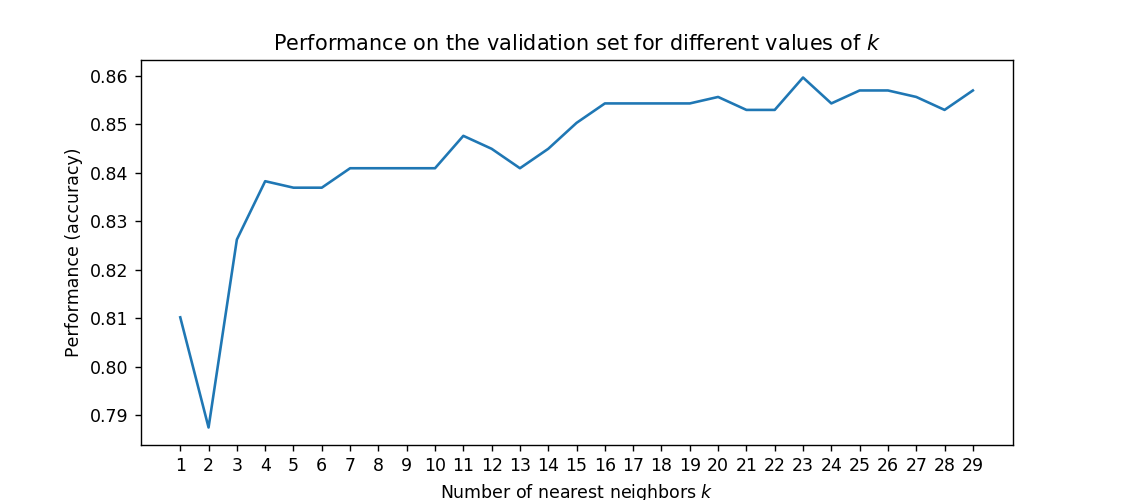

In [21]:
# Visualize the performances for different values of k

k_values = range(1, 30)          # Try these values for hyperparameter k
k_fold = 4
model_performance= run_cv_for_hyperparam(k_values,k_fold,norm_train_features,training_labels)

plt.figure(figsize=(9,4))
plt.title("Performance on the validation set for different values of $k$")
plt.plot(k_values, model_performance)
plt.xlabel("Number of nearest neighbors $k$")
plt.xticks(k_values)
plt.ylabel("Performance (accuracy)");

In [22]:
# Pick hyperparameter value that yields the best performance
best_k = k_values[np.argmax(model_performance)]

print(f"Best number of nearest neighbors on validation set is k={best_k}")

Best number of nearest neighbors on validation set is k=23


What about for very large values of $k$?

<IPython.core.display.Javascript object>


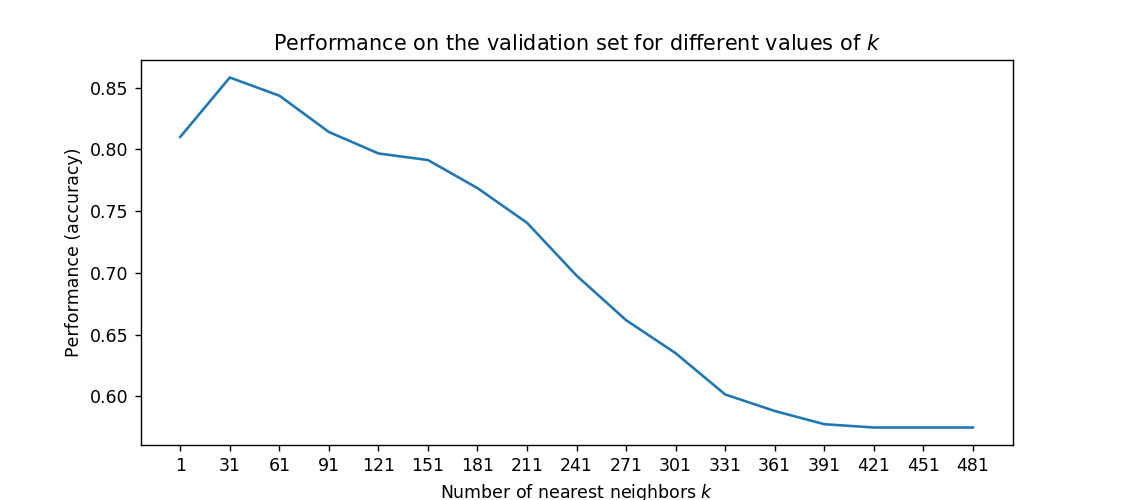

In [23]:
# Visualize the performances for different values of k

k_values = range(1, 500, 30)          # Try these values for hyperparameter k
k_fold = 4
model_performance= run_cv_for_hyperparam(k_values,k_fold,norm_train_features,training_labels)

plt.figure(figsize=(9,4))
plt.title("Performance on the validation set for different values of $k$")
plt.plot(k_values, model_performance)
plt.xlabel("Number of nearest neighbors $k$")
plt.xticks(k_values)
plt.ylabel("Performance (accuracy)");
    

### 4.6 Does the final model generalize to unseen test data?

Now that the model has been tuned, it can be applied for prediction on the test set using the optimal $k$ found through cross-validation.

In [24]:
# get the labels on the test-set using the best k value after CV
predicted_test_labels = kNN(norm_test_features, norm_train_features, training_labels, best_k)

<IPython.core.display.Javascript object>


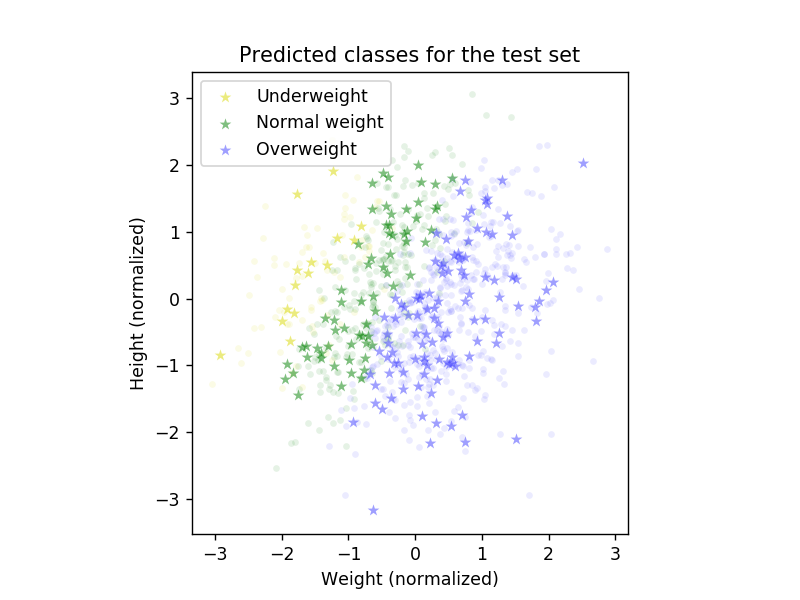

In [25]:
# Visualize the predictions on the test set

plt.figure()
plt.title("Predicted classes for the test set")
for i, class_name in enumerate(class_names):
    plt.scatter(*norm_train_features[training_labels==i].T,
                c=colors[i, None], alpha=0.1, s=15, lw=0)
for i, class_name in enumerate(class_names):    
    plt.scatter(*norm_test_features[predicted_test_labels==i].T,
                c=colors[i, None], marker='*', alpha=0.5, s=50, lw=0, label=class_name)
plt.gca().set_aspect('equal')
plt.xlabel("Weight (normalized)")
plt.ylabel("Height (normalized)")
plt.legend();

In [26]:
performance = accuracy(test_labels, predicted_test_labels)
print(f"{best_k}-NN Classifier predicted  {performance:.2%} of the test examples correctly.")

23-NN Classifier predicted  86.70% of the test examples correctly.


The predictions visually seem consistent with what one would expect. Since the metric used here is not ideal for multiclass classification, it should not be alarming that the value is lower than the one obtained from the validation set.

## 5. Predicting on unannotated data

The model is now finally ready to be applied for prediction on unannotated data.

In [27]:
# Data loading and preparation for unannotated data
features_unannotated = np.load(features_unannotated_path)
norm_features_unannotated = normalize(features_unannotated, mean_features, std_features)

In [28]:
# Get predicted labeles for unannotated data.
predicted_labels_unannotated = kNN(norm_features_unannotated, norm_train_features, training_labels, best_k)

<IPython.core.display.Javascript object>


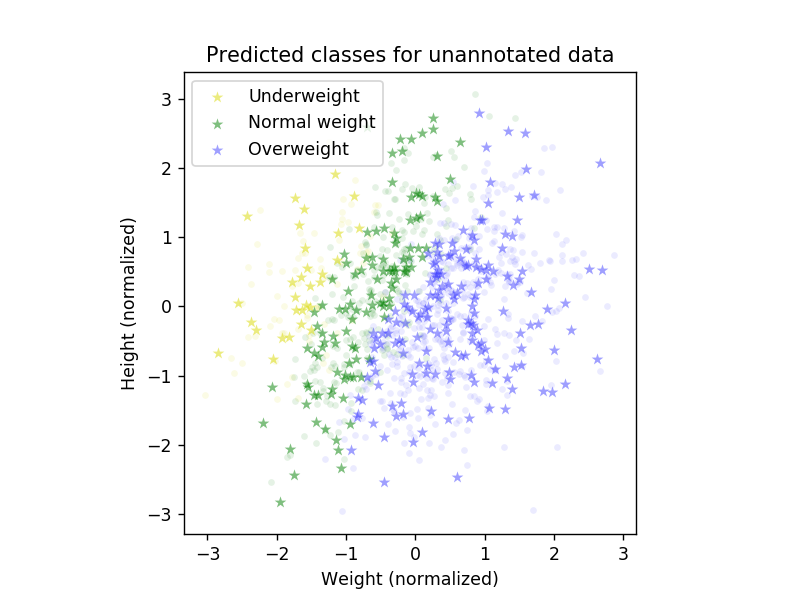

In [29]:
# Visualize the predictions on the unannoated set

plt.figure()
plt.title("Predicted classes for unannotated data")
for i, class_name in enumerate(class_names):
    plt.scatter(*norm_train_features[training_labels==i].T,
                c=colors[i, None], alpha=0.1, s=15, lw=0)
for i, class_name in enumerate(class_names):    
    plt.scatter(*norm_features_unannotated[predicted_labels_unannotated==i].T,
                c=colors[i, None], marker='*', alpha=0.5, s=50, lw=0, label=class_name)
plt.gca().set_aspect('equal')
plt.xlabel("Weight (normalized)")
plt.ylabel("Height (normalized)")
plt.legend();